# **Creazione di modelli per la classificazione di emozioni da file audio .wav**

**Corso**: Big Data

**Professore**: Diego Angelo Gaetano Reforgiato Recupero

**Studenti**: Daniele Lurani, Lorenzo Susino


## **Importazioni e configurazioni iniziali**
In questa sezione vengono importate le librerie necessarie per il progetto (ad esempio, `pandas`, `numpy`, `matplotlib`, ecc.) e configurati eventuali parametri di visualizzazione o impostazioni iniziali per il notebook.


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.version)
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc=spark.sparkContext

--2025-03-13 16:29:52--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M  27.9MB/s    in 13s     

2025-03-13 16:30:06 (29.3 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]

<module 'pyspark.version' from '/content/spark-3.5.5-bin-hadoop3/python/pyspark/version.py'>


In [2]:
!pip install librosa
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [3]:
import librosa
import numpy
import pandas
import matplotlib
import sklearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/BigData_Project/dataset'
english_path = base_path + '/english'
german_path = base_path + '/german'
french_path = base_path + '/french'

Mounted at /content/drive


## **Funzioni di estrazione features**

Questa sezione si occupa di definire le funzioni che verranno utilizzate per la lettura dei file e per l'estrazione delle feature in parallelo.

In [5]:
# Funzione per estrarre le features audio

def audio_features_extraction(audio_path):

    features = []

    try:

        audio_signal, sample_rate = librosa.load(audio_path, sr=None)

        # features mfccs
        mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13)
        mfccs_mean = numpy.mean(mfccs, axis=1)

        # features chroma
        chroma = librosa.feature.chroma_stft(y = audio_signal, sr = sample_rate)
        chroma_mean = numpy.mean(chroma, axis = 1)

        # features spectrum
        spec_contrast = librosa.feature.spectral_contrast(y= audio_signal, sr=sample_rate)
        spec_contrast_mean = numpy.mean(spec_contrast, axis=1)

        features = numpy.concatenate((mfccs_mean, chroma_mean, spec_contrast_mean))

        return features

    except Exception as e:

        print(f"Errore con il file {audio_path}: {e}")
        return None

# Funzione per creare lista di file audio
def load_audio_files(directory):
    audio_files = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".wav"):
                audio_files.append((os.path.join(root, filename),))
    return audio_files

# Parallelizza l'estrazione delle features
def process_partition(partition):
    results = []
    for row in partition:
        file_path = row.file_path
        features = audio_features_extraction(file_path)
        if features is not None:
            results.append((file_path, features.tolist()))
    return iter(results)



## **Lavoro su Dataset Francese**

In questa sezione viene effettuata l'analisi delle emozioni di un dataset in lingua francese basandosi su feature audio e su modelli supervisionati

### Estrazione features e settaggio dei DataFrame

Preprocessing del dataset:
- Creazione del DataFrame pandas
- Inserimento nel DataFrame delle features estratte in precedenza per il rispettivo file audio
- Inserimento della colonna "target" indicante l'emzione corrispondente al file audio
- Split del dataset in train e test sets


In [6]:
from pyspark.sql.functions import split, size, col
from sklearn.model_selection import train_test_split

# Carica file audio in un DataFrame Spark
audio_files_path = load_audio_files(french_path)
df = spark.createDataFrame(audio_files_path, ["file_path"])


In [7]:
# Usiamo RDD per parallelizzare
features_rdd = df.rdd.mapPartitions(process_partition)
features_df = features_rdd.toDF(["file_path", "features"])
features_df = features_df.withColumn("emotion", split(col("file_path"), "/")[size(split(col("file_path"), "/")) - 2])

In [8]:
# Converto in pandas per scikit-learn
pandas_df = features_df.toPandas()

# Espando le features in colonne separate
expanded_features = pandas.DataFrame(pandas_df["features"].to_list(), columns=[f"ft_{i+1}" for i in range(32)])

# Aggiungo i percorsi dei file audio nel DataFrame finale
expanded_features["file_path"] = pandas_df["file_path"]
expanded_features["emotion"] = pandas_df["emotion"]

# Tolgo la colonna file_path
expanded_features = expanded_features.drop(columns=["file_path"])

# Dataset finale da utilizzare
french_df = expanded_features

# Split del dataset
french_df_target = french_df[['emotion']].copy()
french_df_features = french_df.drop(columns=['emotion'])

X_train, X_test, Y_train, Y_test = train_test_split(french_df_features, french_df_target, test_size=0.2)

Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()


### Random Forest e Gradient Boosting

Selezione delle features tramite PCA (per testare in caso migliori i modelli)



In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

pca = PCA(n_components=12)
X_test_pca = pca.fit_transform(X_test_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)


Creazione e addestramento del modello, dopo attenti test abbiamo deciso di non applicare la PCA poiché dall'analisi delle metriche è risultato che peggiora le performance dei modelli.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

french_rf_model = RandomForestClassifier()

french_rf_model.fit(X_train, Y_train)

french_rf_pred = french_rf_model.predict(X_test)

french_rf_proba = french_rf_model.predict_proba(X_test)

# Metriche
fra_rf_accuracy = accuracy_score(Y_test, french_rf_pred)
fra_rf_precision = precision_score(Y_test, french_rf_pred, average='weighted')
fra_rf_f1 = f1_score(Y_test, french_rf_pred, average='weighted')
fra_rf_auc = roc_auc_score(Y_test, french_rf_proba, multi_class='ovr')

print("French dataset Random Forest metrics:\n")
print(f"Accuracy: {fra_rf_accuracy:.4f}")
print(f"Precision: {fra_rf_precision:.4f}")
print(f"F1-Score: {fra_rf_f1:.4f}")
print(f"AUC-ROC: {fra_rf_auc:.4f}")


French dataset Random Forest metrics:

Accuracy: 0.3846
Precision: 0.3747
F1-Score: 0.3730
AUC-ROC: 0.7553


In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, log_loss

french_gb_model = GradientBoostingClassifier()

french_gb_model.fit(X_train, Y_train)

french_gb_pred = french_gb_model.predict(X_test)

french_gb_proba = french_gb_model.predict_proba(X_test)

# Metriche
fra_gb_accuracy = accuracy_score(Y_test, french_gb_pred)
fra_gb_precision = precision_score(Y_test, french_gb_pred, average='weighted')
fra_gb_f1 = f1_score(Y_test, french_gb_pred, average='weighted')
fra_gb_auc = roc_auc_score(Y_test, french_gb_proba, multi_class='ovr')

print("French dataset Gradient Boosting metrics:\n")
print(f"Accuracy: {fra_gb_accuracy:.4f}")
print(f"Precision: {fra_gb_precision:.4f}")
print(f"F1-Score: {fra_gb_f1:.4f}")
print(f"AUC-ROC: {fra_gb_auc:.4f}")


French dataset Gradient Boosting metrics:

Accuracy: 0.4462
Precision: 0.4681
F1-Score: 0.4516
AUC-ROC: 0.7625


Selezione delle features tramite LDA

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, Y_train)
X_test_lda = lda.transform(X_test_scaled)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_lda, Y_train)

y_pred = rf_classifier.predict(X_test_lda)
accuracy = accuracy_score(Y_test, y_pred)

print(f'Accuracy di Random Forest dopo LDA: {accuracy:.2f}')

Accuracy di Random Forest dopo LDA: 0.26


In [13]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_lda, Y_train)

y_pred = gb_classifier.predict(X_test_lda)
accuracy = accuracy_score(Y_test, y_pred)

print(f'Accuracy di Gradient Boosting dopo LDA: {accuracy:.2f}')

Accuracy di Gradient Boosting dopo LDA: 0.22


Grafici utili

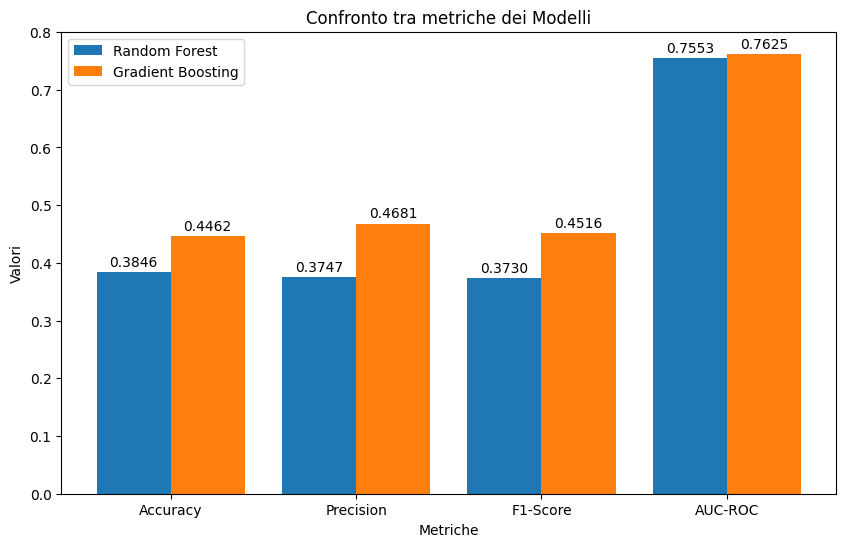

In [14]:
# Confronto metriche Random Forest

import numpy as np
import matplotlib.pyplot as plt

X = ['Accuracy','Precision','F1-Score','AUC-ROC']
rf = [fra_rf_accuracy, fra_rf_precision, fra_rf_f1, fra_rf_auc]
gb = [fra_gb_accuracy, fra_gb_precision, fra_gb_f1, fra_gb_auc]

X_axis = np.arange(len(X))

plt.figure(figsize=(10, 6))

plt.bar(X_axis - 0.2, rf, 0.4, label = 'Random Forest')
plt.bar(X_axis + 0.2, gb, 0.4, label = 'Gradient Boosting')

for i in range(len(X)):
    plt.text(X_axis[i] - 0.2, rf[i] + 0.01, f'{rf[i]:.4f}', ha='center')
    plt.text(X_axis[i] + 0.2, gb[i] + 0.01, f'{gb[i]:.4f}', ha='center')

plt.xticks(X_axis, X)
plt.xlabel("Metriche")
plt.ylabel("Valori")
plt.title("Confronto tra metriche dei Modelli")
plt.legend()
plt.show()
